# Procesamiento de Lenguaje Natural
La **clasificación de texto** es un proceso involucradao en el análisis de sentimientos. Es la clasificación de las opiniones o expresiones de las personas como positivas, neutrales o negativas, por ejemplo. Este análisis de sentimientos puede ser realizado en diferentes industrias centradas en el cliente para analizar la opinión de las personas sobre un producto o tema en concreto.

### Importe de librerías
Se importan todas las librerías necesarias para el proyecto.

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import csv
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import TextVectorization
from keras import layers
from keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###  Preprocesamiento de datos
El `dataset` elegido contiene datos etiquetados de 1.6M de tweets.

In [3]:
# Se pasa el parámetro 'names' para establecer la lista de columnas que tendrá el 'dataframe',
# ya que sin ellos hay errores porque el delimitador (,) aparece en las citas de los tweets y
# crea más columnas de las necesarias
df = pd.read_csv('/content/drive/MyDrive/twitter_dataset.csv', encoding='latin', header=None,
                 names=['sentiment', 'id', 'date', 'query', 'user_id', 'text'])
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Como se ha dicho, el entrenamiento solo va a ser para clasificar los sentimientos según los tweets, por lo que se eliminan las columnas que no sirven, quedando solo las columnas `sentiment` y `text`.

In [4]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Se comprueba cuales son los valores de las etiquetas de salida.

In [5]:
df['sentiment'].value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

La columna `sentiment` tiene dos valores enteros: cero para las opiniones o `tweets` negativos, y cuatro para las opiniones positivas. Por tanto, se va a cambiar el valor de los enteros por estos `strings`.

In [6]:
# Con 'apply' se aplica la función lambda sobre la columna 'sentiment'
df['sentiment'] = df['sentiment'].apply(lambda x: 'Negative' if x == 0 else 'Positive')
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Al usar `tweets`, estos normalmente tienen palabras mal escritas o muchos signos de puntuación emojis y demás elementos que no aportan ningún significado contextual de valor, por lo que hay que deshacerse de ellos.

### Preprocesamiento de texto (columna `text`)
Es hora de limpiar los `tweets` con distintos métodos y técnicas.


#### Stemming/Lemmatization
Los documentos utilizan diferentes formas de una palabra, como *escribir, escribir o escribe.* Además, existen familias de palabras relacionadas con significados similares. El objetivo tanto del *stemming* como de la *lemmatization* es reducir las formas flexivas y derivadas de las palabras para tener solamente una base común para una palabra.

- El *stemming* es un método para reducir una palabra a su raíz.

- La *lemmatization* es el proceso de agrupar conjuntamente las formas flexivas de una palabra de forma que puedan ser analizadas como un solo item, identificados por el lema de la palabra.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/0*a8k0O3iAvWUxCPlX" alt="Stemming y lemmatization"/>
</p>

#### Hipervínculos y menciones
`Twitter` es una red social donde la gente puede etiquetar y mencionar, además de compartir vídeos de internet, por lo que a veces contienen hipervínculos y menciones.

#### Stopwords
Las *Stopwords* o palabras vacías son palabras usadas normalmente que no tienen ningún significado contextual en una frase, por lo que también se deben eliminar. En esta imagen se muestran algunas de ellas:

<p align="center">
  <img src="https://www.researchgate.net/profile/Jennifer-Priestley/publication/318138987/figure/fig8/AS:668237603803162@1536331668931/List-of-Stopwords-in-Text-Mining-Library-of-R.png" alt="stopwords"/>
</p>

Todo este preprocesamiento del texto se va a realizar con la librería `NLTK` de `Python` que tiene funciones para realizar tareas de este tipo para procesamiento del lenguaje natural (`NLP`).

In [7]:
# Lista de 'stopwords' del idioma inglés
stop_words = stopwords.words('english')

# Se inicia un objeto de 'stemming' (elimina sufijos) para el idioma inglés
stemmer = SnowballStemmer('english')

# Expresion regular para filtrar:
# - Las menciones el mayor número de veces posible
# - Los hipervínculos con http
# - Los hipervínculos con https
# - Cualquier caract[^A-Za-z0-9]
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

Se realiza el procesamiento de la columna `text` del `dataframe`.

In [8]:
# Función para preprocesar cada observación o línea de la columna 'text' con
# la función de 'stemming' (eliminado de sufijos) desactivada por defecto
def preprocess(text, stem=False):

  # Se sustituye cualquiera de las 'regular expression' definida arriba por
  # un espacio en la frase del parámetro 'string' (que será la frase de cada observación
  # de la columna 'text' del 'dataframe')
  text = re.sub(pattern=text_cleaning_re, repl=' ', string=str(text).lower()).strip()

  # Se crea una lista vacía
  tokens = []

  # Para cada 'token' (palabra) de la línea...
  for token in text.split():

    # Si el 'token' no está dentro de la lista de 'stopwords', se añade a la
    # lista creada arriba
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)

  # Una vez se tiene toda la lista de palabras sin las 'stopwords', ésta se une
  # mediante un espacio entre cada uno de sus elementos, por lo que al final se
  # retorna una frase
  return " ".join(tokens)

# Se aplica la función definida arriba a la columna 'text'
df['text'] = df['text'].apply(lambda x: preprocess(x))

Ahora la columna `text` esta preprocesada y limpia de hipervínculos, menciones y `stopwords`.

In [9]:
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

### Nube de palabras

Una nube de palabras o nube de etiquetas es una representación visual de las palabras que conforman un texto, en donde el tamaño es mayor para las palabras que aparecen con más frecuencia.

#### Nube de palabras positivas

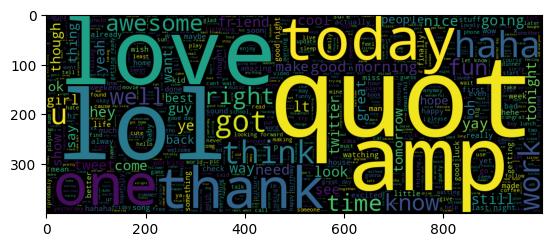

In [10]:
plt.figure()

# Se calcula la nube de palabras positiva con 1000 palabras como máximo a partir
# de la columna 'text' en los que el sentimiento es positivo
wc = WordCloud(max_words=1000, width=1000, height=400).generate(" ".join(df.loc[df['sentiment'] == 'Positive'].text))

# Se muestra la nube de palabras
plt.imshow(wc)

#### Nube de palabras negativas

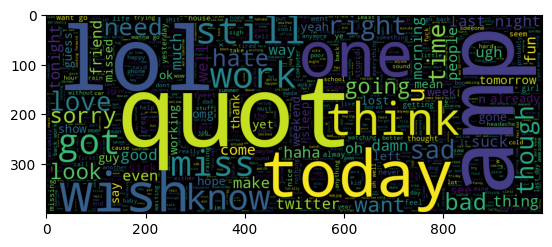

In [11]:
plt.figure()

# Se calcula la nube de palabras positiva con 1000 palabras como máximo a partir
# de la columna 'text' en los que el sentimiento es negativo
wc = WordCloud(max_words=1000, width=1000, height=400).generate(" ".join(df.loc[df['sentiment'] == 'Negative'].text))

# Se muestra la nube de palabras
plt.imshow(wc)

Aunque hay palabras que se repiten en ambas nubes, hay algunas que solo aparecen en la nube de palabras positivas como por ejemplo `love` o `haha`; y otras que solo aparecen en la nube de palabrass negativas, como `miss` o `work`.

### Repartición entrenamiento-test

Una vez procesado el `dataset` y el texto de la columna `text` se realiza la repartición de datos en subconjuntos de entrenamiento, validación y test.

In [12]:
# Repartición entrenamiento/val - test (80% - 20%)
train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=42,
                                             stratify=df['sentiment'])

# Repartición entrenamiento - val (80% - 20%)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42,
                                        stratify=train_val_data['sentiment'])

print("Tamaño subconjunto de entrenamiento:", len(train_data))
print("Tamaño subconjunto de validación:", len(val_data))
print("Tamaño subconjunto de test:", len(test_data))

Tamaño subconjunto de entrenamiento: 1024000
Tamaño subconjunto de validación: 256000
Tamaño subconjunto de test: 320000


Se imprimen las primeras filas del `dataset` de entrenamiento para comprobar que todo se muestra tal y como debería.

In [13]:
train_data.head()

,sentiment,text
134801,Negative,sianysianysiany must twiglets must roast pork ...
1488880,Positive,take time usual job run polling station amp co...
154059,Negative,cannot get creepy sister shit
1309597,Positive,come stay one night hit town
967862,Positive,audio laurenmalone made laugh


### Tokenización

Dada una secuencia de caracteres y una unidad de documento definida, la `tokenización` es la tarea de separarla en trozos llamados `tokens`, desechando quizás, al mismo tiempo, ciertos caracteres sin significado como los signos de puntuación.

Una vez se tienen los distintos `tokens`, estos se mapean a números enteros, de forma que cada uno de ellos se corresponde con un número entero único.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1378/1*3CNBx4iZ1vmJCZgGUIC83A.png" alt="Tokenización"/>
</p>

### Padding

Dado que se va a construir un modelo secuencial, se debe introducir una secuencia de números a dicho modelo. Además, hay que asegurarse que hay homogeneidad en los `shapes` de entrada de las secuencias, es decir, todas ellas deben tener la misma longitud. Como los `tweets` tienen una cantidad variables de caracteres esto también se debe solucionar con alguna técnica, de forma que se rellene o trunque cada `token` a una longitud determinada.

Es decir, siguiendo el ejemplo anterior, cada frase (`tweet`) debe tener el mismo número de `tokens` tras aplicar el `padding`.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*I0JbAgArgFzMCWiOB1o9CQ.png" alt="Padding NLP"/>
</p>

El `tokenizer` y el `padding` se realizaba anteriormente en `Keras` de forma separada con dos funciones: con `Tokenizer` (deprecado) y con `pad_sequences`. Sin embargo, ahora hay una función que realiza ambas cosas conjuntamente, y es `TextVectorization`.

In [14]:
# Se crea una capa de vectorización de texto que mapea el texto a secuencias de
# números enteros (parámetro 'output_mode' como 'int') estableciendo un número
# máximo de 'tokens' a usar (10000) y un máximo de longitud de secuencia (30),
# por lo que se rellena o trunca cada 'token' a esta longitud para que las
# secuencias de todos ellos sean iguales
vectorize_layer = TextVectorization(standardize="lower_and_strip_punctuation",
                                    max_tokens=100000, output_mode="int",
                                    output_sequence_length=30)

# El vectorizador de texto construye el vocabulario a partir de la
# columna 'text' (una serie de 'pandas') del subconjunto de entrenamiento
vectorize_layer.adapt(train_data['text'])

# Se imprime la longitud del vocabulario de 'tokens' (debe ser 1000000)
print(len(vectorize_layer.get_vocabulary()))

100000


### Codificación de las etiquetas

Se construye el modelo para predecir las clases de salida en formato codificado como en los problemas de visión artificial. Así, se tiene `0` o `1` dependiendo de los sentimientos de los `tweets`, por lo que este problema es de clasificación binaria.

In [17]:
# Objeto 'LabelEncoder'
encoder = LabelEncoder()

# Se entrena el objeto 'LabelEncoder' con las etiquetas de entrenamiento
encoder.fit(train_data['sentiment'].to_list())

# Una vez entrenado el objeto, se transforma en los tres subconjuntos
y_train = encoder.transform(train_data['sentiment'].to_list())  # (1024000,)
y_val = encoder.transform(val_data['sentiment'].to_list())
y_test = encoder.transform(test_data['sentiment'].to_list())

# Se hace 'reshape' de las etiquetas para añadir una nueva dimensión
y_train = y_train.reshape(-1,1)                                 # (1024000, 1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

### Word Embedding

En los modelos de lenguaje, las palabras se representan para buscar más significado y para aprender los patrones y el significado contextual detrás de ellas.

El encaje léxico o `word embedding` es una de las representaciones más populares del vocabulario de documentos. Es capaz de capturar el contexto de una palabra en un documento, la similaridad semántica y sintática, las relaciones con otras palabras, etc.

Básicamente, es una representación vectorial de palabras que se utilizan para otras aplicaciones del procesamiento del lenguaje natural.

Se puede entrenar el `embedding`, aunque eso también conlleva que el tiempo de entrenamiento aumente; o se puede hacer `transfer learning` y descargar un `embedding` pre-entrenado y usarlo en el modelo como [GloVe & Word2Vec](https://nlp.stanford.edu/projects/glove/)

### Entrenamiento del modelo
Ya es hora de entrenar el modelo.

Como se pudo comprobar anteriormente en la nube de palabras de ambas clases, hay algunas palabras que se repiten tanto en los `tweets` positivos como negativos. Esto podría ser un problema si utilizamos un modelo de aprendizaje automático como por ejemplo, un clasificador bayesiano. Por este motivo, se usa un modelo secuencial:

<p align="center">
  <img src="https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png" alt="Modelo secuencial"/>
</p>

Las redes neuronales recurrentes pueden manejar una secuencia de datos y aprender un patrón de secuencia de entrada para dar una secuencia o un valor escalar como salida. En estes caso, la red neuronal genera una predicción de un valor escalar.

Para la arquitectura del modelo se usa:

1) **Capa Embedding**: Genera un vector `embedding` para cada secuencia de entrada, es decir, realiza una representación vectorial de cada una de ellas.

2) **Capa Conv1D**: Usada para convolucionar los datos en vectores de características más pequeños.

3) **Capa LSTM (Long Short Term Memory)**: Es una variante de una red neuronal recurrente que tiene una celda de estado de memoria para aprender el contexto de las palabras que se encuentran más adelante en el texto para transmitir un significado contextual.

4) **Capa Densa**: Capa completamente conectada para realizar la clasificación.


In [39]:
# Capa de entrada
sequence_input = layers.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(sequence_input)
x = layers.Embedding(1000 + 1, 128)(x)
x = layers.SpatialDropout1D(0.2)(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
prediction = layers.Dense(1, activation='sigmoid', name='predictions')(x)

# Se construye el modelo especificando la capa de entrada y la de salida
model = tf.keras.Model(inputs=sequence_input, outputs=prediction)

# Resumen del modelo
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, 30, 128)           128128    
                                                                 
 spatial_dropout1d_5 (Spati  (None, 30, 128)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_5 (Conv1D)           (None, 26, 64)            41024     
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               6604

### Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent. You can learn more about Adam [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

### Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

- **LRScheduler** - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

- **ModelCheckPoint** - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [40]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

Let's start training... It takes a heck of a time if training in CPU, be sure your GPU turned on... May the CUDA Cores be with you....

In [35]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on CPU...


In [41]:
history = model.fit(x=train_data['text'], y=y_train, batch_size=1024, epochs=2,
                    validation_data=(val_data, y_val), callbacks=[ReduceLROnPlateau])

Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node model_5/embedding_5/embedding_lookup defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-41-1b13d02324a8>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 272, in call

indices[896,2] = 2290 is not in [0, 1001)
	 [[{{node model_5/embedding_5/embedding_lookup}}]] [Op:__inference_train_function_77793]

# Model Evaluation
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

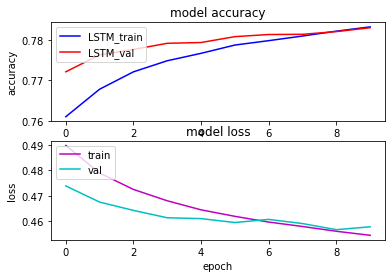

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment.

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

320000/320000 [==============================] - 4s 14us/sample


### Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

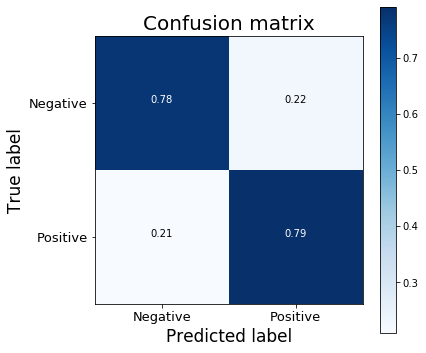

In [ ]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

### Classification Scores

In [ ]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.78    160542
    Positive       0.78      0.79      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



It's a pretty good model we trained here in terms of NLP. Around 80% accuracy is good enough considering the baseline human accuracy also pretty low in these tasks. Also, you may go on and explore the dataset, some tweets might have other languages than English. So our Embedding and Tokenizing wont have effect on them. But on practical scenario, this model is good for handling most tasks for Sentiment Analysis.

<h3>Some of the resource and people who help me learn some concepts</h3>
<font color='#008080'>
    <ul>
        <li> <b>Andrew NG's Seqence Model Course</b> at <a href="https://www.coursera.org/learn/nlp-sequence-models"> Coursera</a> </li>
    
<li> <b>Andrej Karpathy's Blog</b> on <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">Effectiveness of RNN</a></li>

<li> <b>Intuitive Understanding of GloVe Embedding</b> on <a href="https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010">TDS</a></li>

<li> <b>Keras tutorial on Word Embedding</b> <a href="https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html"> here</a></li>

</ul>
</font>

> <font color='#696969'>I got to say like you, I am still at learning phase in terms of NLP. I have got lot to learn in future. I found that writing this notebook even though it is done by lot of people before me helps me with a deeper and complete understanding our the concepts that I am learning. Kaggle has been a amazing place to learn from and contribute to community of Data Science Aspirants.</font>

<h2><font color='red'> If you find this notebook usefull kindly UPVOTE this notebook. I am new to writting notebooks hope that would really encourage me to write and learn more.</font></h2>

<h5>Thanks in Advance. Have a nice day. Learn more and Happy Kaggle</h5>